In [ ]:
## averages stereo to make mono
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

In [ ]:
def squash(x):
    return torch.sigmoid(x)

def squash_neg(x):
    s = squash(x)
    return  s * (1 - s)

def custom_relu(x, inflection_point=2):
    """
    Custom ReLU function where values below the inflection point are zero,
    and values above the inflection point are linear.
    """
    return torch.maximum(torch.zeros_like(x), x - inflection_point)

class PhaseAgreementLoss(nn.Module):
    def __init__(self):
        super(PhaseAgreementLoss, self).__init__()
    
    def forward(self, input, target):
        product = input * target
        loss = torch.sum(squash_neg(product))
        return loss
    
class AmplitudeAgreementLoss(nn.Module):
    def __init__(self):
        super(AmplitudeAgreementLoss, self).__init__()
        
    
    def forward(self, input, target):
        sdif = torch.square(input - target)
        loss = custom_relu(sdif,2)
        return torch.sum(loss)

In [ ]:



class WaveformDataset(Dataset):
    def __init__(self, wav_data):
        self.wav_data = wav_data
        self.time_steps = np.arange(waveform.shape[0])
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

class RandomBatchSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size

    def __iter__(self):
        indices = torch.randperm(len(self.data_source)).tolist()
        for i in range(0, len(indices), self.batch_size):
            yield indices[i:i + self.batch_size]

    def __len__(self):
        return len(self.data_source) // self.batch_size

In [ ]:
sample_rate = 44100  # Sample rate
duration = 0.5  # Duration in seconds
time_steps = sample_rate * duration
t = torch.from_numpy(np.arange(time_steps))

In [ ]:
import matplotlib.pyplot as plt

def plot_two_sine_wave_outputs(t, output1, output2):
    """
    Plots two network outputs against time.

    Parameters:
    t (torch.Tensor): The time tensor.
    output1 (torch.Tensor): The first output of the network.
    output2 (torch.Tensor): The second output of the network.
    """
    t_np = t.detach().cpu().numpy()  # Convert tensor to numpy array
    output1_np = output1.detach().cpu().numpy()  # Convert tensor to numpy array
    output2_np = output2.detach().cpu().numpy()  # Convert tensor to numpy array

    plt.figure(figsize=(10, 6))
    plt.plot(t_np, output1_np, label='Sine Wave Output 1')
    plt.plot(t_np, output2_np, label='Sine Wave Output 2')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine Wave Network Outputs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_gradients_over_time(gradients, title, id = 0):
    gradients = np.array(gradients)
    num_params = gradients.shape[1]
    plt.figure(figsize=(12, 6))
    for i in range(num_params):
        plt.plot(gradients[:, i], label=f'Param {i}')
    plt.title(title)
    plt.xlabel('Step')
    plt.ylabel('Gradient Value')
    plt.legend()
    plt.show()
    
# Example usage
# Ensure t, output1, and output2 are defined before calling this function
# plot_two_sine_wave_outputs(t, output1, output2)


In [ ]:
class SineWaveLayer(nn.Module):
    def __init__(self, n, sample_rate):
        super(SineWaveLayer, self).__init__()
        self.n = n
        self.sample_rate = sample_rate

        # Create frequency and wavelength tensors
        self.frequencies = torch.tensor([sample_rate / (2 ** i) for i in range(n)], dtype=torch.float32)
        self.wavelengths = torch.tensor([2 ** i for i in range(n)], dtype=torch.float32)
        
        # Initialize Amplitude with normal distribution between 0 and 1
        self.amplitudes = nn.Parameter(torch.randn(n))
        
        # Initialize Phi with normal distribution between 0 and corresponding wavelength
        self.phi = nn.Parameter(torch.abs(torch.randn(n)) % self.wavelengths)

    def forward(self, t):
        
        # Expand frequencies and phi to match the shape of t
        frequencies = self.frequencies.unsqueeze(1)  # Shape: (n, 1)
        phi = self.phi.unsqueeze(1)  # Shape: (n, 1)
        amplitudes = self.amplitudes.unsqueeze(1)  # Shape: (n, 1)

        # Compute the sine waves and sum them
        waves = amplitudes * torch.sin(2 * torch.pi * frequencies * (t + phi) / self.sample_rate)  # Shape: (n, time_steps)
        y = waves.sum(dim=0)  # Sum over all waves, shape: (time_steps,)

        return y
    
    def phi_center(self):
        with torch.no_grad():
            self.phi[self.phi > 0] = self.wavelengths[self.phi > 0] + self.phi[self.phi > 0]
            self.phi[self.phi < 0] = self.wavelengths[self.phi < 0] + self.phi[self.phi < 0]
    
    def freeze_parameters(self):
        for param in self.parameters():
            param.requires_grad = False
    
    def set_parameters_and_freeze(self, amplitudes, phi, freq):
        with torch.no_grad():
            self.amplitudes.copy_(torch.tensor(amplitudes, dtype=torch.float32))
            self.phi.copy_(torch.tensor(phi, dtype=torch.float32))
            self.frequencies.copy_(torch.tensor(freq, dtype=torch.float32)) 
        self.freeze_parameters()
        
class SineWaveLayerAdd(nn.Module):
    def __init__(self, n, sample_rate):
        super(SineWaveLayerAdd, self).__init__()
        self.n = n
        self.sample_rate = sample_rate

        # Create frequency and wavelength tensors
        self.frequencies = torch.tensor([sample_rate*2 / (2 + i) for i in range(n)], dtype=torch.float32)
        self.wavelengths = torch.tensor([2 + i for i in range(n)], dtype=torch.float32)
        
        # Initialize Amplitude with normal distribution between 0 and 1
        self.amplitudes = nn.Parameter(torch.randn(n))
        
        # Initialize Phi with normal distribution between 0 and corresponding wavelength
        self.phi = nn.Parameter(torch.abs(torch.randn(n)) % self.wavelengths)

    def forward(self, t):
        
        # Expand frequencies and phi to match the shape of t
        frequencies = self.frequencies.unsqueeze(1)  # Shape: (n, 1)
        phi = self.phi.unsqueeze(1)  # Shape: (n, 1)
        amplitudes = self.amplitudes.unsqueeze(1)  # Shape: (n, 1)

        # Compute the sine waves and sum them
        waves = amplitudes * torch.sin(2 * torch.pi * frequencies * (t + phi) / self.sample_rate)  # Shape: (n, time_steps)
        y = waves.sum(dim=0)  # Sum over all waves, shape: (time_steps,)

        return y
    
    def phi_center(self):
        with torch.no_grad():
            self.phi[self.phi > 0] = self.wavelengths[self.phi > 0] + self.phi[self.phi > 0]
            self.phi[self.phi < 0] = self.wavelengths[self.phi < 0] + self.phi[self.phi < 0]
    
    def freeze_parameters(self):
        for param in self.parameters():
            param.requires_grad = False
    
    def set_parameters_and_freeze(self, amplitudes, phi, freq):
        with torch.no_grad():
            self.amplitudes.copy_(torch.tensor(amplitudes, dtype=torch.float32))
            self.phi.copy_(torch.tensor(phi, dtype=torch.float32))
            self.frequencies.copy_(torch.tensor(freq, dtype=torch.float32)) 
        self.freeze_parameters()

class SineWaveLayerHigh(nn.Module):
    def __init__(self, n, m, sample_rate):
        super(SineWaveLayerHigh, self).__init__()
        self.n = n 
        self.m = m
        self.sample_rate = sample_rate

        # Create frequency tensors
        self.low_frequencies = torch.tensor([sample_rate*2 / (2 + i) for i in range(n)], dtype=torch.float32)
        self.high_frequencies = torch.tensor([sample_rate + sample_rate/(i+1) for i in range(m)], dtype=torch.float32)
        self.frequencies = torch.cat((self.low_frequencies, self.high_frequencies), dim=0)

        # Create wavelength tensors for n and m frequencies
        self.wavelengths = torch.tensor([2 + i for i in range(n)] + [sample_rate + sample_rate/(i+1) for i in range(m)], dtype=torch.float32)
        
        # Initialize Amplitude with normal distribution
        self.amplitudes = nn.Parameter(torch.randn(n + m))
        
        # Initialize Phi with normal distribution between 0 and corresponding wavelength
        self.phi = nn.Parameter(torch.abs(torch.randn(n + m)) % self.wavelengths)

    def forward(self, t):
        # Expand frequencies and phi to match the shape of t
        frequencies = self.frequencies.unsqueeze(1)  # Shape: (n+m, 1)
        phi = self.phi.unsqueeze(1)  # Shape: (n+m, 1)
        amplitudes = self.amplitudes.unsqueeze(1)  # Shape: (n+m, 1)

        # Compute the sine waves and sum them
        waves = amplitudes * torch.sin(2 * torch.pi * frequencies * (t + phi) / self.sample_rate)  # Shape: (n+m, time_steps)
        y = waves.sum(dim=0)  # Sum over all waves, shape: (time_steps,)

        return y
    
    def phi_center(self):
        with torch.no_grad():
            self.phi[self.phi > 0] = self.wavelengths[self.phi > 0] + self.phi[self.phi > 0]
            self.phi[self.phi < 0] = self.wavelengths[self.phi < 0] + self.phi[self.phi < 0]
    
    def freeze_parameters(self):
        for param in self.parameters():
            param.requires_grad = False
    
    def set_parameters_and_freeze(self, amplitudes, phi, freq):
        with torch.no_grad():
            self.amplitudes.copy_(torch.tensor(amplitudes, dtype=torch.float32))
            self.phi.copy_(torch.tensor(phi, dtype=torch.float32))
            self.all_frequencies.copy_(torch.tensor(freq, dtype=torch.float32)) 
        self.freeze_parameters()

class SineWaveLayerInc(nn.Module):
    def __init__(self, n, sample_rate):
        super(SineWaveLayerInc, self).__init__()
        self.n = n
        self.sample_rate = sample_rate

        # Create frequency and wavelength tensors
        self.frequencies = torch.tensor([sample_rate / (1 + i) for i in range(n)], dtype=torch.float32)
        self.wavelengths = torch.tensor([2 + i for i in range(n)], dtype=torch.float32)
        
        # Initialize Amplitude with normal distribution between 0 and 1
        self.amplitudes = nn.Parameter(torch.randn(n))
        
        # Initialize Phi with normal distribution between 0 and corresponding wavelength
        self.phi = nn.Parameter(torch.abs(torch.randn(n)) % self.wavelengths)

    def forward(self, t):
        t = t.to(dtype=torch.float32)
        y = torch.zeros_like(t)  # Initialize output tensor with the same shape as t
        
        # Iterate through each wave component
        for i in range(self.n):
            frequency = self.frequencies[i]
            phi = self.phi[i]
            amplitude = self.amplitudes[i]
            
            # Compute the current sine wave component
            wave = amplitude * torch.sin(2 * torch.pi * frequency * (t + phi) / self.sample_rate)
            
            # Accumulate the wave component into the output
            y += wave

        return y
    
    def phi_center(self):
        with torch.no_grad():
            self.phi[self.phi > 0] = self.wavelengths[self.phi > 0] + self.phi[self.phi > 0]
            self.phi[self.phi < 0] = self.wavelengths[self.phi < 0] + self.phi[self.phi < 0]
    
    def freeze_parameters(self):
        for param in self.parameters():
            param.requires_grad = False
    
    def set_parameters_and_freeze(self, amplitudes, phi, freq):
        with torch.no_grad():
            self.amplitudes.copy_(torch.tensor(amplitudes, dtype=torch.float32))
            self.phi.copy_(torch.tensor(phi, dtype=torch.float32))
            self.frequencies.copy_(torch.tensor(freq, dtype=torch.float32)) 
        self.freeze_parameters()
        
        
class SineWaveNetwork(nn.Module):
    def __init__(self, n, sample_rate):
        super(SineWaveNetwork, self).__init__()
        self.n = n
        self.sample_rate = sample_rate
        self.layers = nn.ModuleList([SineWaveLayer(n, sample_rate) for _ in range(n)])

    def forward(self, t):
        # Sum the outputs of all SineWaveLayer instances
        output = sum(layer(t) for layer in self.layers)
        return output
    
    def get_amplitude_parameters(self):
        return [layer.amplitudes for layer in self.layers]

    def get_phi_parameters(self):
        return [layer.phi for layer in self.layers]
        
import random
def generate_random_floats(n):
    return [random.random() for _ in range(n)]



In [80]:
# Example usage
n = 6 #5
sample_rate = 44100
networkT = SineWaveLayer(n, sample_rate)


#amplitudes = [0.5, 0.8, 0.3,1.0,0.2]  # Example values ###works consistently!
#phi = [0.4, 0.02, 0.002,-2.0,0.6]            # Example values
#networkT.set_parameters_and_freeze(amplitudes, phi)

In [8]:
networkT.frequencies
networkT.set_parameters_and_freeze([14], [0.3],[6000.0000])

In [9]:
amplitudes = [66 * x for x in generate_random_floats(n)]
phi = [135 * x for x in generate_random_floats(n)]
f = [14522, 16025.0000,  35532.5000,  12726.2, 13024.8,9423.5]
networkT.set_parameters_and_freeze(amplitudes, phi,f) #set teacher
amplitudes,phi, f

([5.810268141866224,
  24.08667950153174,
  11.247671902673309,
  62.74690647690874,
  58.77179980577985,
  29.967754260780993],
 [108.43341049444808,
  65.07959131871311,
  82.16790952652268,
  41.282338172447915,
  34.90507572605369,
  118.24781926218533],
 [14522, 16025.0, 35532.5, 12726.2, 13024.8, 9423.5])

In [25]:
answer_a = networkT.amplitudes
answer_p = networkT.phi

In [81]:
############################# graphing stuff!!!
graph_t = t[0:100]
graph_output = networkT(graph_t)
waveform = graph_output.float()

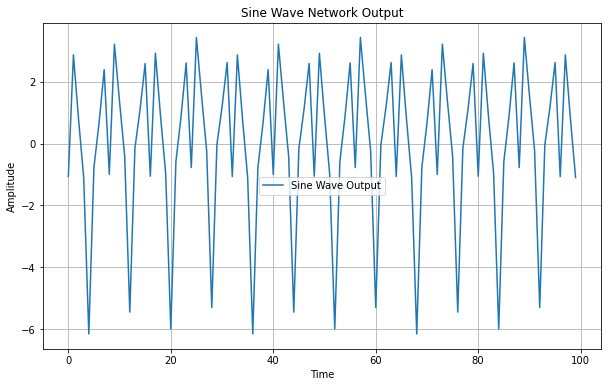

In [82]:
def plot_sine_wave_output(t, output):
    """
    Plots the network output against time.

    Parameters:
    t (torch.Tensor): The time tensor.
    output (torch.Tensor): The output of the network.
    """
    t_np = t.detach().cpu().numpy()  # Convert tensor to numpy array
    output_np = output.detach().cpu().numpy()  # Convert tensor to numpy array

    plt.figure(figsize=(10, 6))
    plt.plot(t_np, output_np, label='Sine Wave Output')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine Wave Network Output')
    plt.legend()
    plt.grid(True)
    plt.show()



plot_sine_wave_output(graph_t,graph_output)

In [83]:
networkT.freeze_parameters()

In [84]:
n = 6 # Set above
m = 10
sample_rate = 44100 
network = SineWaveLayer(n, sample_rate)
#network = SineWaveNetwork(n, sample_rate)
#network = SineWaveLayerAdd(n, sample_rate)

#network = SineWaveLayerHigh(n,m, sample_rate)
#network = SineWaveLayerInc(n, sample_rate)
# Set the layer to training mode
network.train()

SineWaveLayer()

In [85]:
network.frequencies, network.wavelengths

(tensor([44100.0000, 22050.0000, 11025.0000,  5512.5000,  2756.2500,  1378.1250]),
 tensor([ 1.,  2.,  4.,  8., 16., 32.]))

In [86]:
#this trains them seperately. 

# Define a loss function and optimizer
hyperparameters = {'learning_rate': 0.0001
                   , 'epochs': 10000
                   ,'batch_size': 100}

# Create the dataloader with the custom random batch sampler
dataset = WaveformDataset(waveform)
batch_size = hyperparameters['batch_size']
sampler = RandomBatchSampler(dataset, batch_size)
dataloader = DataLoader(dataset, batch_sampler=sampler)

#criterion = nn.MSELoss()
#criterion = PhaseAgreementLoss()
#optimizer = optim.Adam([network.amplitudes, network.phi], lr=hyperparameters['learning_rate'])

#for layer
optimizer_amplitudes = optim.Adam([network.amplitudes], lr=0.01) #is mle correct?
optimizer_phi = optim.Adam([network.phi], lr=0.0001)  
#for network
#optimizer_amplitudes = optim.Adam(network.get_amplitude_parameters(), lr=0.001)
#optimizer_phi = optim.Adam(network.get_phi_parameters(), lr=0.001)  
    # Define loss functions
criterion_mse = nn.MSELoss() #AmplitudeAgreementLoss() 
criterion_phase_agree = PhaseAgreementLoss()


# Create objects to hold gradients
amplitude_grads = []
phi_grads = []


# Training loop
for epoch in range(hyperparameters['epochs']):
    running_loss_mse = 0.0
    running_loss_pa = 0.0
    
    for i, (batch_wav, batch_time) in enumerate(dataloader):
    
    
        # Zero the parameter gradients
        #optimizer.zero_grad()
        optimizer_amplitudes.zero_grad()
        optimizer_phi.zero_grad()
        
        
        # Forward pass
        output = network(batch_time)

        # Calculate loss
        #loss = criterion(output, batch_wav)
        loss_mse = criterion_mse(output, batch_wav)
        loss_phase_agree = criterion_phase_agree(output, batch_wav)
        
        loss_mse.backward(retain_graph=True) 
        loss_phase_agree.backward()
        
        optimizer_phi.step()
        optimizer_amplitudes.step()
        #network.phi_center() # not working the way i think.
        # Backward pass and optimize
        #loss.backward()

        # Print gradients before optimization step
        #print(f"Epoch {epoch} - Gradients for amplitudes before step:", network.amplitudes.grad[0])
        #print(f"Epoch {epoch} - Gradients for phi before step:", network.phi.grad)
        
        ##adjust grad if you wanna.
        #network.phi.grad -= network.phi.grad
        #network.amplitudes.grad /= network.frequencies
        
        
        # Append gradients to the lists
        amplitude_grads.append(network.amplitudes.grad.detach().cpu().numpy().copy())
        phi_grads.append(network.phi.grad.detach().cpu().numpy().copy())
        
        
        #optimizer.step()


        # Apply phi_center adjustment
        #network.phi_center()

        # Print statistics
        #running_loss += loss.item()
        
        running_loss_mse += loss_mse.item()
        running_loss_pa += loss_phase_agree.item()
    
    
    if (epoch%1000==0):
        print(f"Epoch {epoch} - Running Loss MSE: {running_loss_mse} - Phase Agreement: {loss_phase_agree}")


print('Finished Training')

Epoch 0 - Running Loss MSE: 12.87402629852295 - Phase Agreement: 14.983960151672363


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [76]:
print(network.amplitudes,network.phi)

Parameter containing:
tensor([0.9800, 0.2884, 0.7058, 0.9788, 1.6515, 1.7089], requires_grad=True) Parameter containing:
tensor([ 0.1653,  0.2184,  1.3378, -1.3872,  0.8898,  0.4792],
       requires_grad=True)


In [77]:
print(networkT.amplitudes,networkT.phi)

Parameter containing:
tensor([ 5.8103, 24.0867, 11.2477, 62.7469, 58.7718, 29.9678]) Parameter containing:
tensor([108.4334,  65.0796,  82.1679,  41.2823,  34.9051, 118.2478])


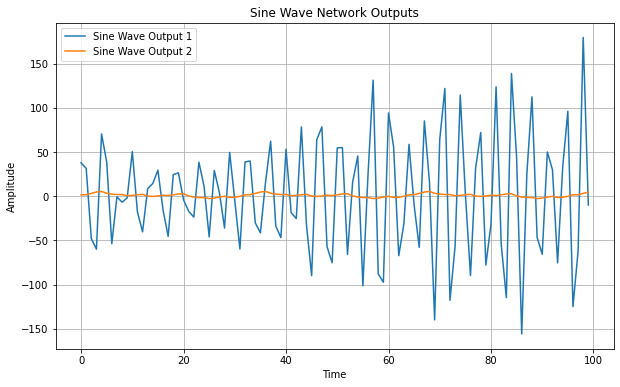

In [78]:
plot_two_sine_wave_outputs(graph_t, waveform, network(graph_t))

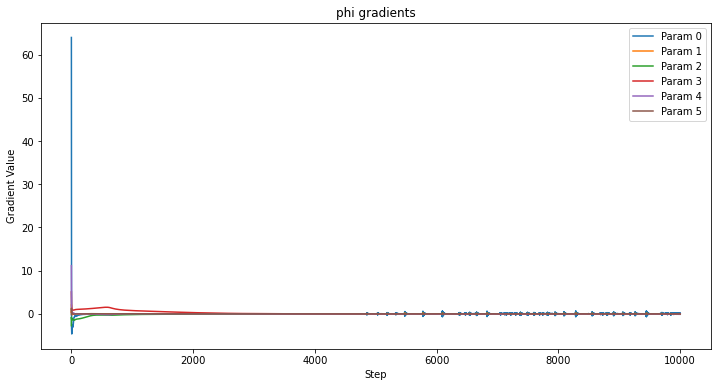

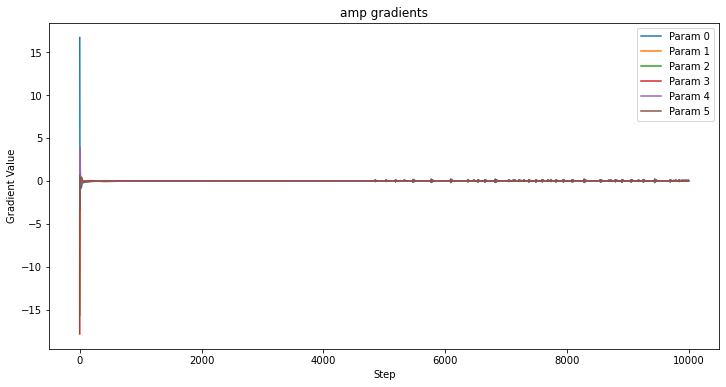

In [79]:
plot_gradients_over_time(phi_grads, "phi gradients")
plot_gradients_over_time(amplitude_grads, "amp gradients")

In [22]:
amplitude_grads[0]

array([-1.3050423 ,  6.600443  ,  0.51196027, -0.80161   ,  7.1334696 ,
       26.949432  ,  1.3495415 , -5.1795816 ,  1.9248667 , -2.21951   ,
       -1.991549  ,  0.641562  , -6.979205  , -3.8778152 , -5.4465523 ,
       -0.38616705,  2.2087593 ,  0.12969375, -0.91822803, -3.493796  ],
      dtype=float32)

In [23]:
#mle doesn't tune phase well.  i think i want cosine with like, a smoothing flattening effect.  i want no gradient if its all in the right order, but if lots of positive and negatives it should move. 

In [24]:
the phi loss needs to check the consistency along the phase.  not sure i need to line up, but i can if i gotta.  
see notebook.  i like my little loss

SyntaxError: invalid syntax (2903216984.py, line 1)

In [ ]:
def generate_sine_wave(phase_shift=0, num_samples=100, amplitude=1, frequency=1, sampling_rate=100):
    x = np.linspace(0, 2 * np.pi, num_samples)
    y = amplitude * np.sin(frequency * x + phase_shift)
    return torch.tensor(y, dtype=torch.float32)

# Parameters
num_samples = 100
amplitude = 1
frequency = 1
sampling_rate = 100
phi_values = np.linspace(0, 2 * np.pi, num_samples)

# Generate the original sine wave
sine_wave = generate_sine_wave(num_samples=num_samples, amplitude=amplitude, frequency=frequency, sampling_rate=sampling_rate)

# Calculate phase agreement loss for each phase shift
criterion = PhaseAgreementLoss()
losses = []

for phi in phi_values:
    shifted_sine_wave = generate_sine_wave(phase_shift=phi, num_samples=num_samples, amplitude=amplitude, frequency=frequency, sampling_rate=sampling_rate)
    loss = criterion(sine_wave, shifted_sine_wave).item()
    losses.append(loss)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(phi_values, losses, label='Phase Agreement Loss')
plt.xlabel('Phase Shift (radians)')
plt.ylabel('Phase Agreement Loss')
plt.title('Phase Agreement Loss for Different Phase Shifts')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
44100.0000 /29400.0000

In [ ]:
50*50*2 

In [ ]:
4 bytes per float:0.005MB wtf 1000x compression.  